In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./detailed_meals_macros_CLEANED.csv')
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,...,Dinner Protein.1,Dinner Carbohydrates.1,Dinner Fats,Snack Suggestion,Snacks Calories,Snacks Protein,Snacks Carbohydrates,Snacks Fats,Disease,Lunch Fats
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,...,60.0,250.0,60.0,Greek yogurt with fruit,150,10,20,5,Weight Gain,12.0
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,...,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,"Weight Gain, Hypertension, Heart Disease",8.0
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,...,55.0,150.0,15.0,Trail mix,300,8,34,20,Weight Gain,15.0
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,...,20.0,163.0,27.0,Banana with peanut butter,210,5,30,9,Weight Gain,10.0
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,...,6.3,186.0,22.0,Fruit and nut mix,250,6,28,15,Weight Gain,9.0


In [6]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

In [8]:
correlation_matrix = df[numeric_columns].corr()

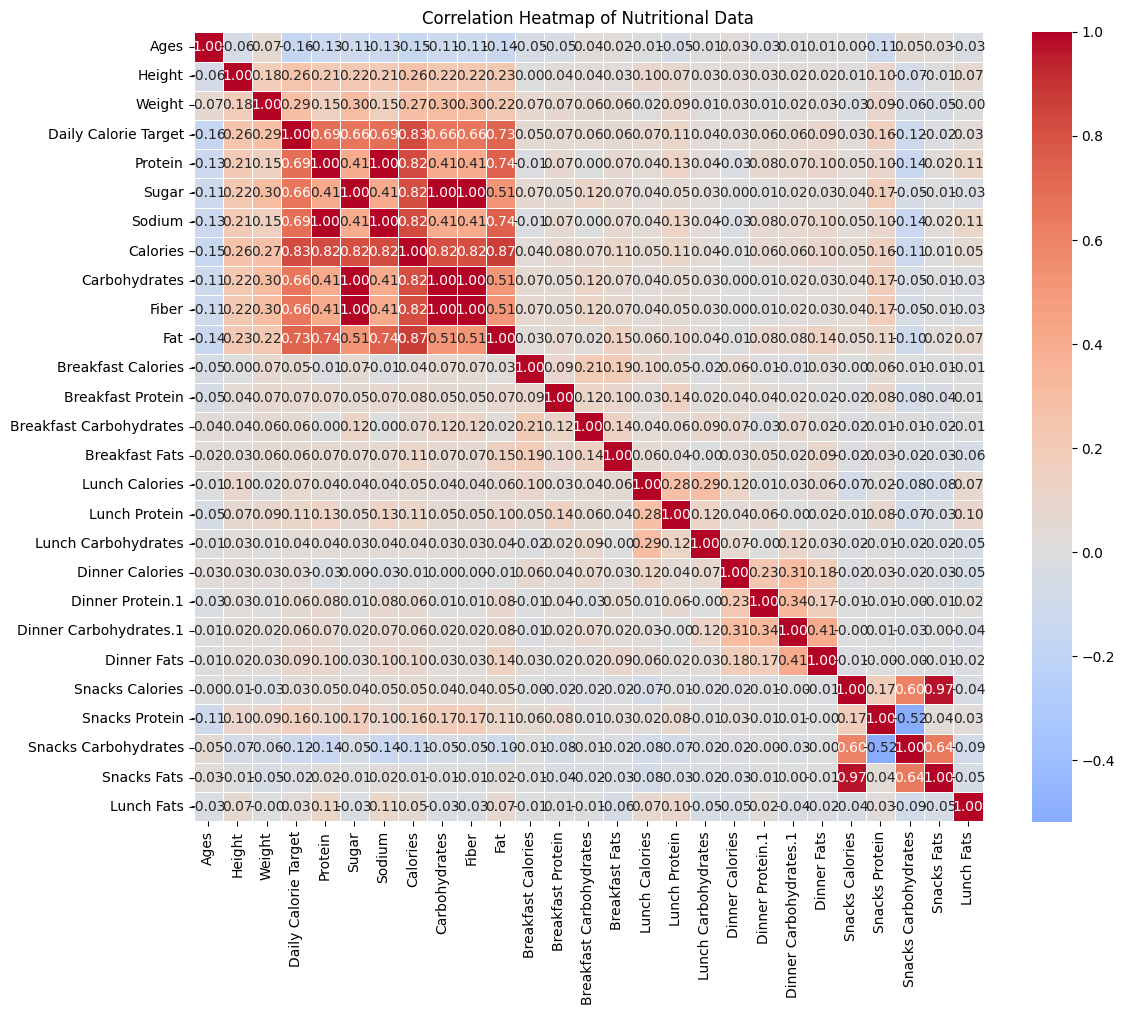

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Nutritional Data')
plt.tight_layout()
plt.show()

In [10]:
df_selected = df[['Ages', 'Weight', 'Height', 'Daily Calorie Target', 'Protein', 'Calories', 'Fat', 'Carbohydrates']]
df_selected.head()

,Ages,Weight,Height,Daily Calorie Target,Protein,Calories,Fat,Carbohydrates
0,25,80,180,2000,120,2020,60,250
1,32,65,165,1600,80,1480,40,200
2,48,95,175,2200,100,2185,65,300
3,55,70,160,2500,140,2680,80,350
4,62,85,170,2000,80,1815,55,250


In [12]:
selected_numeric_columns = df_selected.columns

In [13]:
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    
    for column in columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    
    return df_cleaned

df_no_outliers = remove_outliers_iqr(df_selected, selected_numeric_columns)

print(f"Original dataset shape: {df_selected.shape}")
print(f"Dataset after removing outliers: {df_no_outliers.shape}")
print(f"Removed {df_selected.shape[0] - df_no_outliers.shape[0]} rows with outliers")

Original dataset shape: (1698, 8)
Dataset after removing outliers: (1687, 8)
Removed 11 rows with outliers


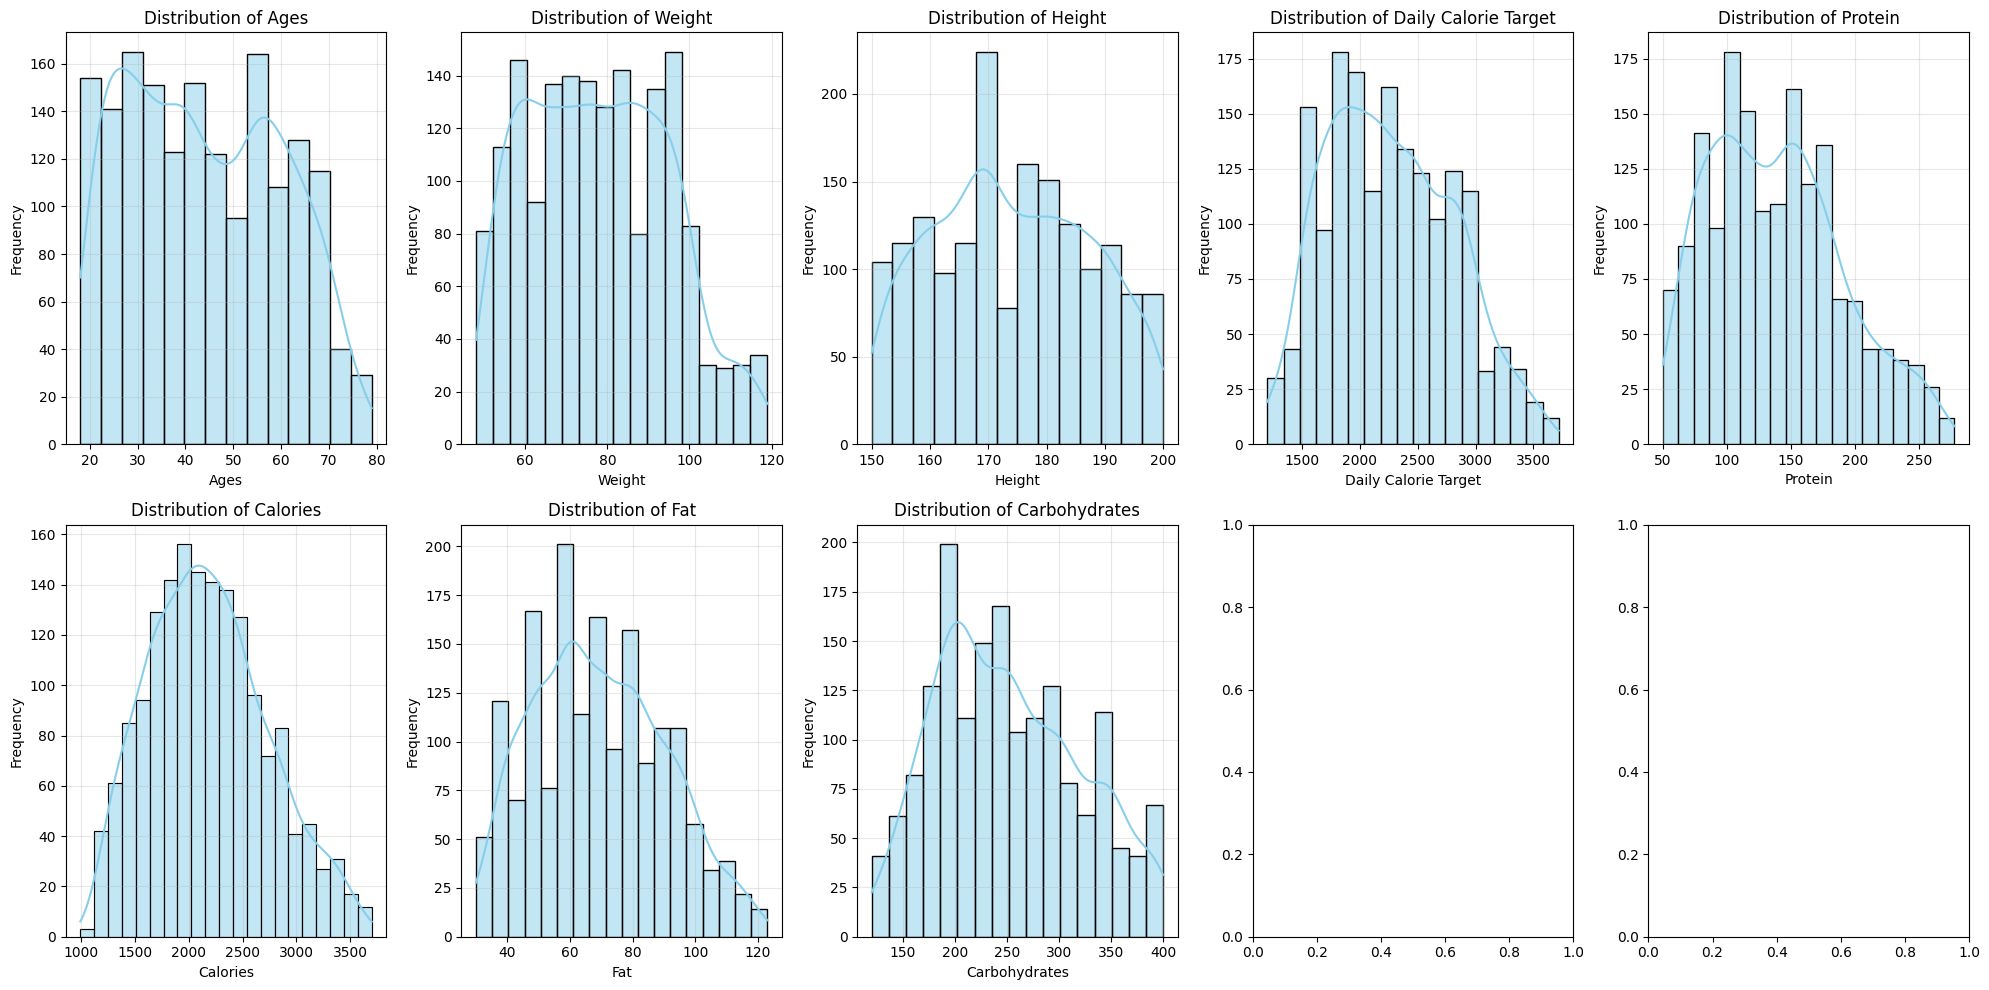

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, column in enumerate(selected_numeric_columns):
    sns.histplot(data=df_no_outliers, x=column, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
df_no_outliers['BMI'] = df_no_outliers['Weight'] / (df_no_outliers['Height'] / 100) ** 2

In [38]:
def bmi_underweight(bmi):
    if bmi <= 0:
        return 1
    elif 0 < bmi < 17:
        return 1
    elif 17 <= bmi < 18.5:
        return (18.5 - bmi) / (18.5 - 17)
    else:
        return 0

def bmi_normal(bmi):
    if bmi < 17:
        return 0
    elif 17 <= bmi < 18.5:
        return (bmi - 17) / (18.5 - 17)
    elif 18.5 <= bmi < 23:
        return 1
    elif 23 <= bmi < 24.9:
        return (24.9 - bmi) / (24.9 - 23)
    else:
        return 0

def bmi_overweight(bmi):
    if bmi < 23:
        return 0
    elif 23 <= bmi < 25:
        return (bmi - 23) / (25 - 23)
    elif 25 <= bmi < 28:
        return 1
    elif 28 <= bmi < 29.9:
        return (29.9 - bmi) / (29.9 - 28)
    else:
        return 0

def bmi_obese(bmi):
    if bmi < 28:
        return 0
    elif 28 <= bmi < 30:
        return (bmi - 28) / (30 - 28)
    elif 30 <= bmi <= 40:
        return 1
    else:
        return 0

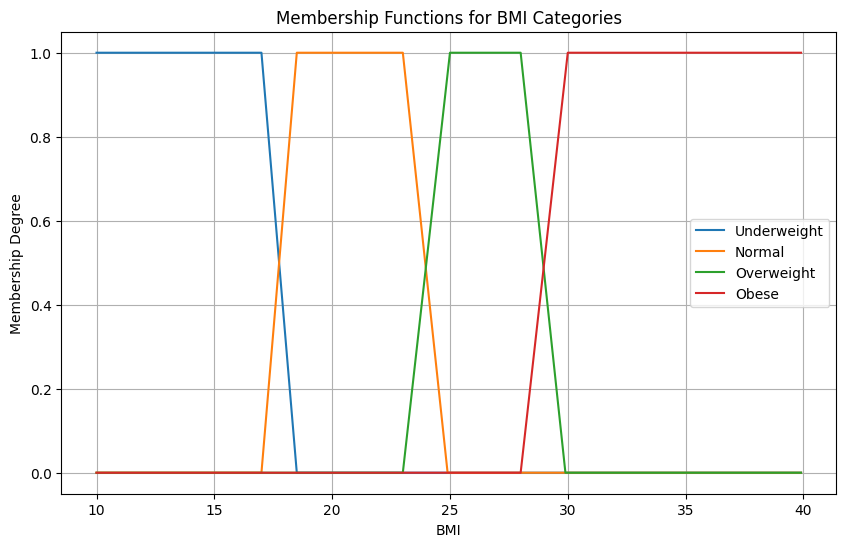

In [39]:
x_bmi = np.arange(10, 40, 0.1)

underweight = [bmi_underweight(x) for x in x_bmi]
normal = [bmi_normal(x) for x in x_bmi]
overweight = [bmi_overweight(x) for x in x_bmi]
obese = [bmi_obese(x) for x in x_bmi]

# Plot the membership functions
plt.figure(figsize=(10, 6))
plt.plot(x_bmi, underweight, label='Underweight')
plt.plot(x_bmi, normal, label='Normal')
plt.plot(x_bmi, overweight, label='Overweight')
plt.plot(x_bmi, obese, label='Obese')

plt.title('Membership Functions for BMI Categories')
plt.xlabel('BMI')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
def young(age):
    if age <= 25: 
        return 1
    elif 25 < age <= 40:
        return (40 - age) / (40 - 25)
    else:
        return 0

def middle(age):
    if age <= 30 or age >= 60:
        return 0
    elif 30 < age <= 45:
        return (age - 30) / (45 - 30)
    elif 45 < age <= 60:
        return (60 - age) / (60 - 45)
    else:
        return 0

def senior(age):
    if age <= 50:
        return 0
    elif 50 < age <= 65:
        return (age - 50) / (65 - 50)
    elif 65 < age <= 80:
        return 1
    else:
        return 0

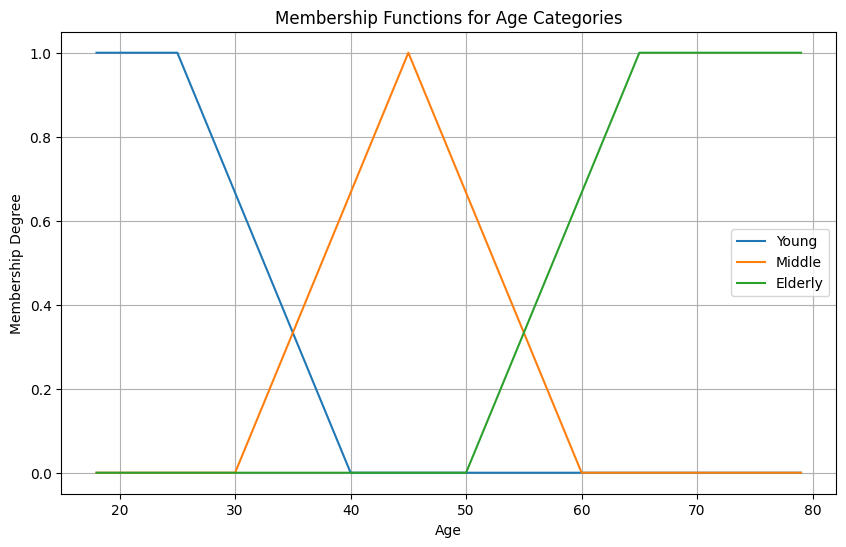

In [41]:
x_age = np.arange(18, 80, 1)
young_membership = [young(x) for x in x_age]
middle_membership = [middle(x) for x in x_age]
elderly_membership = [senior(x) for x in x_age]

# Plot the membership functions
plt.figure(figsize=(10, 6))
plt.plot(x_age, young_membership, label='Young')
plt.plot(x_age, middle_membership, label='Middle')
plt.plot(x_age, elderly_membership, label='Elderly')

plt.title('Membership Functions for Age Categories')
plt.xlabel('Age')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def low_calories(kcal):
    if kcal <= 1800:
        return 1
    elif 1800 < kcal <= 2000:
        return (2000 - kcal) / (2000 - 1800)
    else:
        return 0

def moderate_calories(kcal):
    if kcal <= 1600 or kcal >= 2600:
        return 0
    elif 1600 < kcal <= 2000:
        return (kcal - 1600) / (2000 - 1600)
    elif 2000 < kcal <= 2200:
        return 1
    elif 2200 < kcal <= 2600:
        return (2600 - kcal) / (2600 - 2200)
    else:
        return 0

def high_calories(kcal):
    if kcal <= 2200:
        return 0
    elif 2200 < kcal <= 2400:
        return (kcal - 2200) / (2400 - 2200)
    elif kcal > 2400:
        return 1
    else:
        return 0

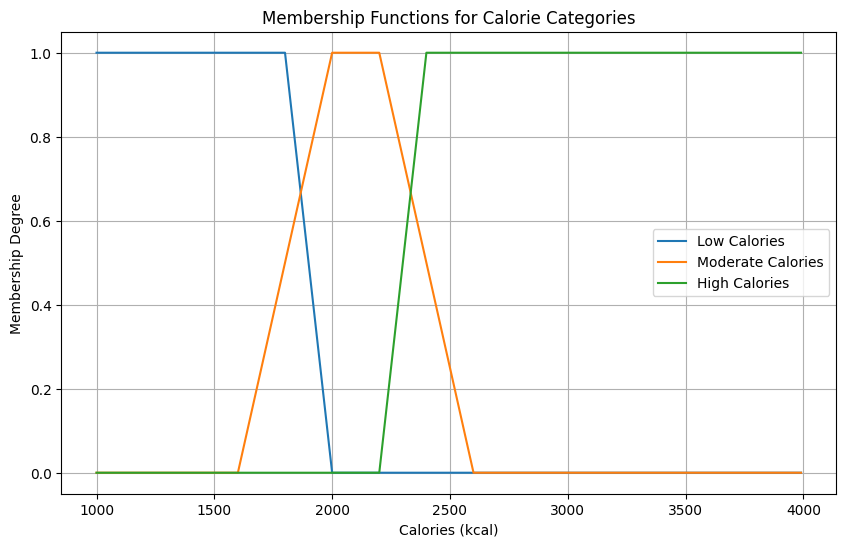

In [43]:
x_calories = np.arange(1000, 4000, 10)
low_cal_membership = [low_calories(x) for x in x_calories]
moderate_cal_membership = [moderate_calories(x) for x in x_calories]
high_cal_membership = [high_calories(x) for x in x_calories]

# Plot the membership functions
plt.figure(figsize=(10, 6))
plt.plot(x_calories, low_cal_membership, label='Low Calories')
plt.plot(x_calories, moderate_cal_membership, label='Moderate Calories')
plt.plot(x_calories, high_cal_membership, label='High Calories')

plt.title('Membership Functions for Calorie Categories')
plt.xlabel('Calories (kcal)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
def fuzzify_bmi(bmi_value):
    return {
        'underweight': bmi_underweight(bmi_value), 
        'normal': bmi_normal(bmi_value),
        'overweight': bmi_overweight(bmi_value),
        'obese': bmi_obese(bmi_value),
    }

def fuzzify_age(age_value):
    return {
        'young': young(age_value),
        'middle': middle(age_value),
        'senior': senior(age_value),
    }

def fuzzify_calories(calorie_value):
    return {
        'low': low_calories(calorie_value),
        'moderate': moderate_calories(calorie_value),
        'high': high_calories(calorie_value),
    }

# Visualization functions (examples)
def bmi_fuzzification_viz(bmi):
    fuzzified_bmi = fuzzify_bmi(bmi)
    df = pd.DataFrame([fuzzified_bmi])
    df.index = [f"BMI: {bmi}"]
    return df

def age_fuzzification_viz(age):
    fuzzified_age = fuzzify_age(age)
    df = pd.DataFrame([fuzzified_age])
    df.index = [f"Age: {age}"]
    return df

def calorie_fuzzification_viz(calories):
    fuzzified_calories = fuzzify_calories(calories)
    df = pd.DataFrame([fuzzified_calories])
    df.index = [f"Calories: {calories}"]
    return df


In [45]:
bmi_fuzzification_viz(22.5)

,underweight,normal,overweight,obese
BMI: 22.5,0,1,0,0


In [46]:
age_fuzzification_viz(30)

,young,middle,senior
Age: 30,0.666667,0,0


In [47]:
calorie_fuzzification_viz(1850)

,low,moderate,high
Calories: 1850,0.75,0.625,0


In [48]:
bmi_terms = {
    "underweight": bmi_underweight, 
    "normal": bmi_normal,
    "overweight": bmi_overweight,
    "obese": bmi_obese,
}

age_terms = {
    "young": young,
    "middle": middle,
    "senior": senior,
}

# output terms
calorie_terms = {
    "low": low_calories,
    "moderate": moderate_calories,
    "high": high_calories,
}

# Define comprehensive fuzzy rules for calorie recommendation
def fuzzy_rules_calories(bmi_value, age_value):
    """
    Apply fuzzy rules to determine calorie recommendation based on BMI and age.
    Returns the aggregated output membership values for each calorie category.
    """
    
    # Fuzzify inputs
    bmi_membership = fuzzify_bmi(bmi_value)
    age_membership = fuzzify_age(age_value)
    
    # Initialize output aggregation
    output_low = 0
    output_moderate = 0
    output_high = 0
    
    # Rule 1: IF BMI is underweight AND age is young THEN calories should be high
    rule1_strength = min(bmi_membership['underweight'], age_membership['young'])
    output_high = max(output_high, rule1_strength)
    
    # Rule 2: IF BMI is underweight AND age is middle THEN calories should be high
    rule2_strength = min(bmi_membership['underweight'], age_membership['middle'])
    output_high = max(output_high, rule2_strength)
    
    # Rule 3: IF BMI is underweight AND age is senior THEN calories should be moderate
    rule3_strength = min(bmi_membership['underweight'], age_membership['senior'])
    output_moderate = max(output_moderate, rule3_strength)
    
    # Rule 4: IF BMI is normal AND age is young THEN calories should be moderate
    rule4_strength = min(bmi_membership['normal'], age_membership['young'])
    output_moderate = max(output_moderate, rule4_strength)
    
    # Rule 5: IF BMI is normal AND age is middle THEN calories should be moderate
    rule5_strength = min(bmi_membership['normal'], age_membership['middle'])
    output_moderate = max(output_moderate, rule5_strength)
    
    # Rule 6: IF BMI is normal AND age is senior THEN calories should be low
    rule6_strength = min(bmi_membership['normal'], age_membership['senior'])
    output_low = max(output_low, rule6_strength)
    
    # Rule 7: IF BMI is overweight AND age is young THEN calories should be low
    rule7_strength = min(bmi_membership['overweight'], age_membership['young'])
    output_low = max(output_low, rule7_strength)
    
    # Rule 8: IF BMI is overweight AND age is middle THEN calories should be low
    rule8_strength = min(bmi_membership['overweight'], age_membership['middle'])
    output_low = max(output_low, rule8_strength)
    
    # Rule 9: IF BMI is overweight AND age is senior THEN calories should be low
    rule9_strength = min(bmi_membership['overweight'], age_membership['senior'])
    output_low = max(output_low, rule9_strength)
    
    # Rule 10: IF BMI is obese AND age is young THEN calories should be low
    rule10_strength = min(bmi_membership['obese'], age_membership['young'])
    output_low = max(output_low, rule10_strength)
    
    # Rule 11: IF BMI is obese AND age is middle THEN calories should be low
    rule11_strength = min(bmi_membership['obese'], age_membership['middle'])
    output_low = max(output_low, rule11_strength)
    
    # Rule 12: IF BMI is obese AND age is senior THEN calories should be low
    rule12_strength = min(bmi_membership['obese'], age_membership['senior'])
    output_low = max(output_low, rule12_strength)
    
    return {
        'low': output_low,
        'moderate': output_moderate,
        'high': output_high
    }

# Test the rules with sample values
sample_bmi = 22.5
sample_age = 30

rule_output = fuzzy_rules_calories(sample_bmi, sample_age)
print(f"For BMI={sample_bmi} and Age={sample_age}:")
print(f"Low calories membership: {rule_output['low']:.3f}")
print(f"Moderate calories membership: {rule_output['moderate']:.3f}")
print(f"High calories membership: {rule_output['high']:.3f}")

For BMI=22.5 and Age=30:
Low calories membership: 0.000
Moderate calories membership: 0.667
High calories membership: 0.000


In [49]:
z_samples = np.arange(10, 2000, 5)
z_samples

array([  10,   15,   20,   25,   30,   35,   40,   45,   50,   55,   60,
         65,   70,   75,   80,   85,   90,   95,  100,  105,  110,  115,
        120,  125,  130,  135,  140,  145,  150,  155,  160,  165,  170,
        175,  180,  185,  190,  195,  200,  205,  210,  215,  220,  225,
        230,  235,  240,  245,  250,  255,  260,  265,  270,  275,  280,
        285,  290,  295,  300,  305,  310,  315,  320,  325,  330,  335,
        340,  345,  350,  355,  360,  365,  370,  375,  380,  385,  390,
        395,  400,  405,  410,  415,  420,  425,  430,  435,  440,  445,
        450,  455,  460,  465,  470,  475,  480,  485,  490,  495,  500,
        505,  510,  515,  520,  525,  530,  535,  540,  545,  550,  555,
        560,  565,  570,  575,  580,  585,  590,  595,  600,  605,  610,
        615,  620,  625,  630,  635,  640,  645,  650,  655,  660,  665,
        670,  675,  680,  685,  690,  695,  700,  705,  710,  715,  720,
        725,  730,  735,  740,  745,  750,  755,  7

In [50]:
def maximize_threshold(z_samples, output_membership):
    clipped = {}
    for term, threshold in output_membership.items():
        # Ensure membership function exists for the term
        if term in calorie_terms:
            clipped[term] = [min(calorie_terms[term](z), threshold) for z in z_samples]
        else:
            clipped[term] = [0] * len(z_samples) # Handle terms without defined membership function
    df = pd.DataFrame(clipped, index=z_samples)
    return clipped, df

clipped_membership, clipped_df = maximize_threshold(z_samples, fuzzy_rules_calories(sample_bmi, sample_age))
clipped_df['Max Membership'] = clipped_df.max(axis=1)
clipped_df

,low,moderate,high,Max Membership
10,0,0.000000,0,0.000000
15,0,0.000000,0,0.000000
20,0,0.000000,0,0.000000
25,0,0.000000,0,0.000000
30,0,0.000000,0,0.000000
...,...,...,...,...
1975,0,0.666667,0,0.666667
1980,0,0.666667,0,0.666667
1985,0,0.666667,0,0.666667
1990,0,0.666667,0,0.666667


In [51]:
clipped_df['zi * Max Membership'] = clipped_df.index * clipped_df['Max Membership']

# Calculate the sums
sum_max_membership = clipped_df['Max Membership'].sum()
sum_zi_max_membership = (clipped_df.index * clipped_df['Max Membership']).sum()

# Append the summary row
summary_row = pd.DataFrame(
    {
        'Max Membership': [sum_max_membership],
        'zi * Max Membership': [sum_zi_max_membership]
    },
    index=['Sum']
)

# Display the table with the summary row
display(pd.concat([clipped_df, summary_row]))


,low,moderate,high,Max Membership,zi * Max Membership
10,0.0,0.000000,0.0,0.000000,0.000000
15,0.0,0.000000,0.0,0.000000,0.000000
20,0.0,0.000000,0.0,0.000000,0.000000
25,0.0,0.000000,0.0,0.000000,0.000000
30,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...
1980,0.0,0.666667,0.0,0.666667,1320.000000
1985,0.0,0.666667,0.0,0.666667,1323.333333
1990,0.0,0.666667,0.0,0.666667,1326.666667
1995,0.0,0.666667,0.0,0.666667,1330.000000


In [52]:
crisp_output_mamdani_calories = sum_zi_max_membership / sum_max_membership if sum_max_membership != 0 else 0
print(f"Crisp Output (Recommended Calories Intake): {crisp_output_mamdani_calories:.2f}g")

Crisp Output (Recommended Calories Intake): 1854.20g


In [53]:
constants_calories = {
    "low": 1400,      # Constant value for low calorie recommendation
    "moderate": 2000,  # Constant value for moderate calorie recommendation  
    "high": 2800       # Constant value for high calorie recommendation
}


In [54]:
def crisp_output_sugeno(output_membership, constants): 
    weighted_sum = sum(constants[term] * output_membership[term] for term in output_membership)
    
    sum_memberships = sum(output_membership.values())
    
    if sum_memberships == 0:
        return 0
    
    crisp_output = weighted_sum / sum_memberships
    return crisp_output

In [58]:
crisp_output_sugeno_calories = crisp_output_sugeno(fuzzy_rules_calories(sample_bmi, sample_age), constants_calories)
print(f"Crisp Output (Sugeno Method): {crisp_output_sugeno_calories:.2f} g")

Crisp Output (Sugeno Method): 2000.00 g


In [ ]:
# Create ground truth labels based on actual Daily Calorie Target
def categorize_calories(calorie_value):
    if calorie_value <= 1800:
        return 'low'
    elif calorie_value <= 2200:
        return 'moderate'
    else:
        return 'high'

# Create evaluation dataset
eval_data_calories = df_no_outliers.copy()

# Generate predictions for both methods
mamdani_predictions_calories = []
sugeno_predictions_calories = []

for idx, row in eval_data_calories.iterrows():
    bmi_val = row['BMI']
    age_val = row['Ages']
    
    # Mamdani method
    rule_result = fuzzy_rules_calories(bmi_val, age_val)
    clipped_membership, _ = maximize_threshold(z_samples, rule_result)
    
    # Calculate aggregated membership for Mamdani
    max_membership = []
    for i, z in enumerate(z_samples):
        max_val = max(clipped_membership['low'][i], 
                     clipped_membership['moderate'][i], 
                     clipped_membership['high'][i])
        max_membership.append(max_val)
    
    # Mamdani defuzzification
    sum_zi_max = sum(z_samples[i] * max_membership[i] for i in range(len(z_samples)))
    sum_max = sum(max_membership)
    mamdani_output = sum_zi_max / sum_max if sum_max != 0 else 0
    
    # Determine category for Mamdani
    if mamdani_output <= 1400:
        mamdani_category = 'low'
    elif mamdani_output <= 2000:
        mamdani_category = 'moderate'
    else:
        mamdani_category = 'high'
    
    mamdani_predictions_calories.append(mamdani_category)
    
    # Sugeno method
    sugeno_output = crisp_output_sugeno(rule_result, constants_calories)
    
    # Determine category for Sugeno
    if sugeno_output <= 1600:
        sugeno_category = 'low'
    elif sugeno_output <= 2200:
        sugeno_category = 'moderate'
    else:
        sugeno_category = 'high'
    
    sugeno_predictions_calories.append(sugeno_category)

# Create ground truth
ground_truth_calories = [categorize_calories(target) for target in eval_data_calories['Daily Calorie Target']]

# Encode labels for F1 score calculation
le_calories = LabelEncoder()
le_calories.fit(['low', 'moderate', 'high'])

ground_truth_encoded_calories = le_calories.transform(ground_truth_calories)
mamdani_encoded_calories = le_calories.transform(mamdani_predictions_calories)
sugeno_encoded_calories = le_calories.transform(sugeno_predictions_calories)

# Calculate F1 scores
mamdani_f1_calories = f1_score(ground_truth_encoded_calories, mamdani_encoded_calories, average='weighted')
sugeno_f1_calories = f1_score(ground_truth_encoded_calories, sugeno_encoded_calories, average='weighted')

print("Calorie Recommendation Model Evaluation:")
print(f"Mamdani Method F1 Score: {mamdani_f1_calories:.4f}")
print(f"Sugeno Method F1 Score: {sugeno_f1_calories:.4f}")
print(f"Better Method: {'Mamdani' if mamdani_f1_calories > sugeno_f1_calories else 'Sugeno'}")

Model Accuracy Comparison (Calories):
Mamdani F1 Score: 0.2094
Sugeno F1 Score: 0.2444
\nBetter performing model for Calories: Sugeno


NameError: name 'fuzzify_dct' is not defined